# References / Credits to / Thanks to

- https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial
- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://www.kaggle.com/rohanrao/a-modern-time-series-tutorial
- https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- https://www.kaggle.com/census/population-time-series-data
- https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

## Import Libraries

In [1]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    
from tqdm import tqdm_notebook

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math

%matplotlib inline

In [2]:
## Evaluation Metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read in Data

In [3]:
data = pd.read_csv("../input/sandp500/all_stocks_5yr.csv")

We will only use date and the closing price of Apple Inc. stocks for the purpose of the tutorial.

In [4]:
df = data.copy()[data.Name=='AAPL'][['date','close']]

## Converting Date that is in string/object datatype to datetime datatype

In [5]:
df['date_dt'] = pd.to_datetime(df.date)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 1259 to 2517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1259 non-null   object        
 1   close    1259 non-null   float64       
 2   date_dt  1259 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 39.3+ KB


We can see that the newly created "date_dt" column is not comprised of string values. Instead, they are all datetime values. We can easily apply datetime operations on datatime datatypes (and that is why we often change string dates to datetime dates)

In [7]:
# set the datetime column as the index
df.set_index('date_dt', inplace=True)

## Creating dattimeindex with certain frequencies

In [8]:
# datetimeindex with daily frequency
dti_df = pd.date_range(start='7/1/20', end='7/8/20')

dti_df

DatetimeIndex(['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08'],
              dtype='datetime64[ns]', freq='D')

In [9]:
# Creating a datetimeindex with monthly frequency
dti_mf = pd.date_range(start='1/1/20', end='7/1/20', freq='M')

dti_mf

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30'],
              dtype='datetime64[ns]', freq='M')

## Creating lagged plots

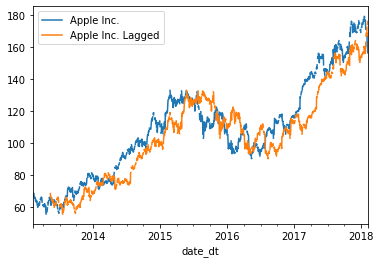

In [10]:
df["close"].asfreq('D').plot(legend=True)
lagged_plot = df["close"].asfreq('D').shift(90).plot(legend=True)
lagged_plot.legend(['Apple Inc.','Apple Inc. Lagged'])

## Resampling

In [11]:
# Downsampling (from daily to monthly; aggregation method: mean)

df['close'].resample('M').mean()

date_dt
2013-02-28     65.306264
2013-03-31     63.120110
2013-04-30     59.966432
2013-05-31     63.778927
2013-06-30     60.791120
                 ...    
2017-10-31    157.817273
2017-11-30    172.406190
2017-12-31    171.891500
2018-01-31    174.005238
2018-02-28    161.468000
Freq: M, Name: close, Length: 61, dtype: float64

In [12]:
# Upsampling (from monthly mean to daily frequency: In this case, filling daily values of the same month with the mean value for that month)

monthly = df['close'].resample('M').mean()
monthly.resample('D').pad()

date_dt
2013-02-28     65.306264
2013-03-01     65.306264
2013-03-02     65.306264
2013-03-03     65.306264
2013-03-04     65.306264
                 ...    
2018-02-24    174.005238
2018-02-25    174.005238
2018-02-26    174.005238
2018-02-27    174.005238
2018-02-28    161.468000
Freq: D, Name: close, Length: 1827, dtype: float64

## Percentage Change Calculations

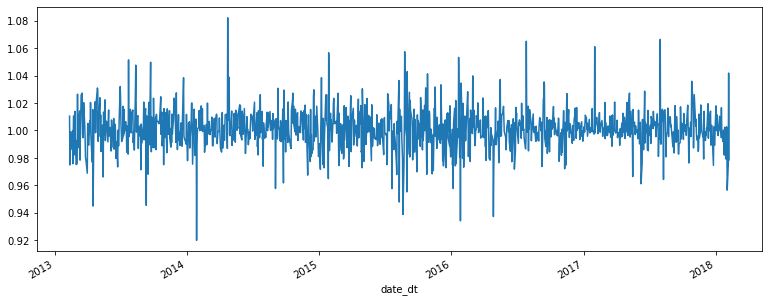

In [13]:
# Percent Change from previous value (Stock price today / stock price yesterday)
df['ch'] = df.close.div(df.close.shift())
df['ch'].plot(figsize=(13,5))

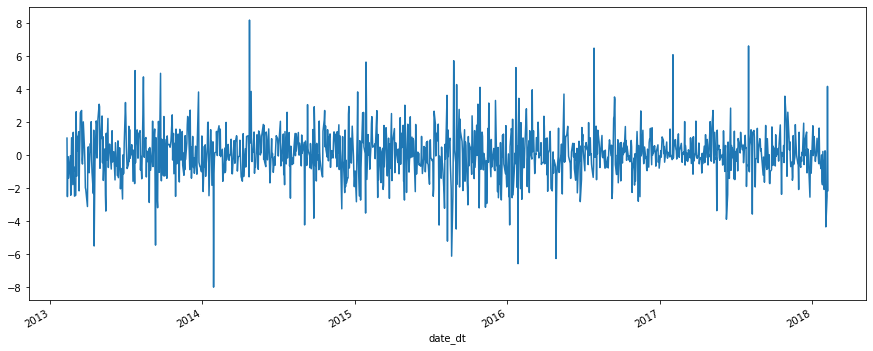

In [14]:
# Returns
df.close.pct_change().mul(100).plot(figsize=(15,6))

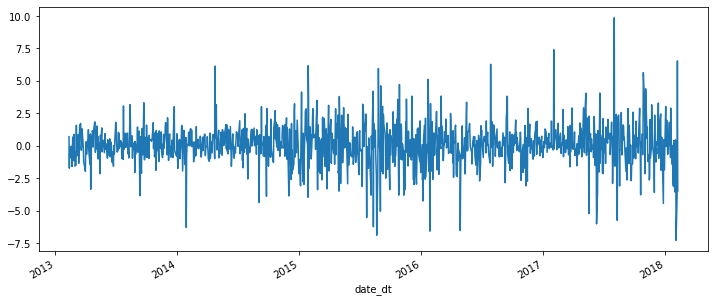

In [15]:
# Absolute change in price
df.close.diff().plot(figsize=(12,5))

## Rolling/Moving/Running Average

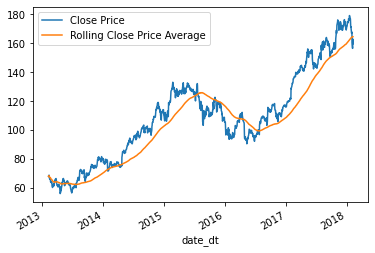

In [16]:
# Using the rolling( ) function
rolling = df.close.rolling('200D').mean()
df.close.plot()
rolling.plot()
plt.legend(['Close Price','Rolling Close Price Average'])

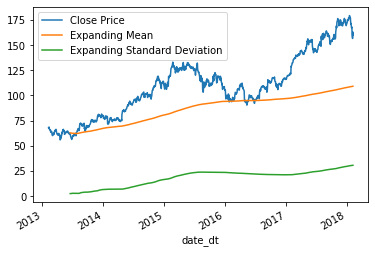

In [17]:
# using the expanding( ) function

expanding_mean = df.close.expanding(90).mean() # average of 90 previous values and itself
expanding_std = df.close.expanding(90).std() # std of 90 previous values and itself

df.close.plot()
expanding_mean.plot()
expanding_std.plot()
plt.legend(['Close Price','Expanding Mean','Expanding Standard Deviation'])

In [18]:
# Calculate average of last n obervations Using self-made function

def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df.close, 90)

168.28788888888892

## Filter only certain days (e.g. Monday, Tuesday)

In [19]:
# Filter only Mondays
mondays = df[df.index.dayofweek.isin([0])]

In [20]:
mondays.head(10)

,date,close,ch
date_dt,,,
2013-02-11,2013-02-11,68.5614,1.010422
2013-02-25,2013-02-25,63.2571,0.982232
2013-03-04,2013-03-04,60.0071,0.975793
2013-03-11,2013-03-11,62.5528,1.014246
2013-03-18,2013-03-18,65.1028,1.027184
2013-03-25,2013-03-25,66.2256,1.003614
2013-04-01,2013-04-01,61.2728,0.968938
2013-04-08,2013-04-08,60.8871,1.007112
2013-04-15,2013-04-15,59.9785,0.976850


## .dt functions / operations

In [21]:
df['index'] = df.index

In [22]:
df["Year"] = df["index"].dt.year
df["Month"] = df["index"].dt.month
df["Day"] = df["index"].dt.day
df["Hour"] = df["index"].dt.hour
df["Minute"] = df["index"].dt.minute
df["Second"] = df["index"].dt.second
df["Nanosecond"] = df["index"].dt.nanosecond
df["Date"] = df["index"].dt.date
df["Time"] = df["index"].dt.time
df["Time_Time_Zone"] = df["index"].dt.timetz
df["Day_Of_Year"] = df["index"].dt.dayofyear
df["Week_Of_Year"] = df["index"].dt.weekofyear
df["Week"] = df["index"].dt.week
df["Day_Of_week"] = df["index"].dt.dayofweek
df["Week_Day"] = df["index"].dt.weekday
# df["Week_Day_Name"] = df["index"].dt.weekday_name
df["Quarter"] = df["index"].dt.quarter
df["Days_In_Month"] = df["index"].dt.days_in_month
df["Is_Month_Start"] = df["index"].dt.is_month_start
df["Is_Month_End"] = df["index"].dt.is_month_end
df["Is_Quarter_Start"] = df["index"].dt.is_quarter_start
df["Is_Quarter_End"] = df["index"].dt.is_quarter_end
df["Is_Leap_Year"] = df["index"].dt.is_leap_year

## Plot Moving Average (including anomalies and confidence intervals)

**Credits and source from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python**

In [23]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

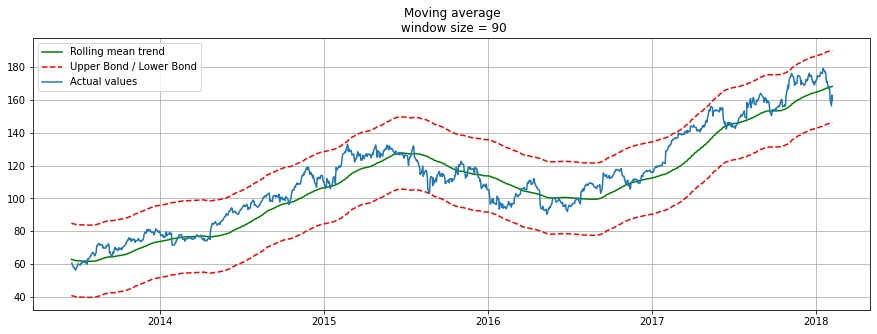

In [24]:
plotMovingAverage(df[['close']], 90, plot_intervals=True, scale=1.96, plot_anomalies=True)

## OHLC and CandleStick Charts for Stock Visualization

In [25]:
data['date_dt'] = pd.to_datetime(data.date)
data.set_index('date_dt',inplace=True)

In [26]:
data_appl = data.copy()[data.Name == 'AAPL']

In [27]:
plt.style.use('fivethirtyeight') 
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# OHLC chart of Feb 2018
trace = go.Ohlc(x=data_appl['2013-02'].index,
                open=data_appl['2013-02'].open,
                high=data_appl['2013-02'].high,
                low=data_appl['2013-02'].low,
                close=data_appl['2013-02'].close)
dataa = [trace]
iplot(dataa, filename='simple_ohlc')

In [28]:
# Candlestick chart of Feb 2018
trace = go.Candlestick(x=data_appl['2013-02'].index,
                open=data_appl['2013-02'].open,
                high=data_appl['2013-02'].high,
                low=data_appl['2013-02'].low,
                close=data_appl['2013-02'].close)
dataa = [trace]
iplot(dataa, filename='simple_candlestick')

## AutoCorrelation and Partial AutoCorrelation

- Autocorrelation (ACF) measures how a series is correlated with itself at different lags.
- Partial Autocorrelation : The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. If all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.
- These are for checking randomness + Used in the model identification stage for Box-Jenkins autoregressive, moving average time series models
- Each spike that rises above or falls below the dashed lines is considered to be statistically significant. This means the spike has a value that is significantly different from zero. If a spike is significantly different from zero, that is evidence of autocorrelation. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero. But data that does not show significant autocorrelation can still exhibit non-randomness in other ways


In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

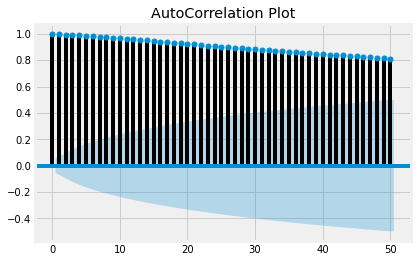

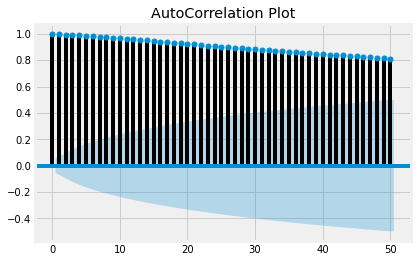

In [30]:
plot_acf(df["close"], lags=50, title="AutoCorrelation Plot")

The bars up until lag = 50 are well beyond the confidence interval (marked / colored in blue) which indicates autocorrelation exists and is statistically significant

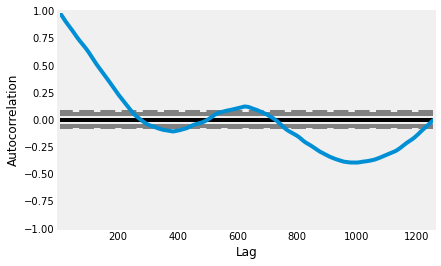

In [31]:
# using pandas plotting lib
pd.plotting.autocorrelation_plot(df.close)

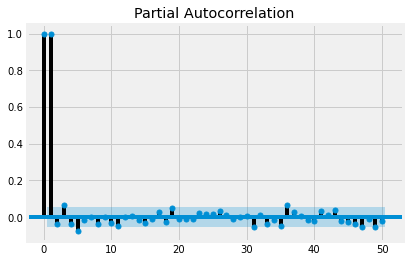

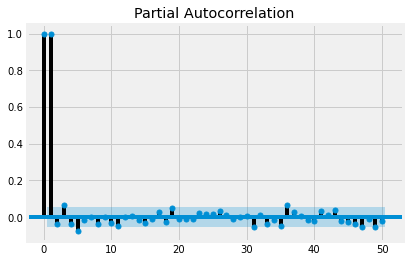

In [32]:
plot_pacf(df["close"],lags=50)

## Stationarity

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.
* Strong stationarity:  is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
* Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time

Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.


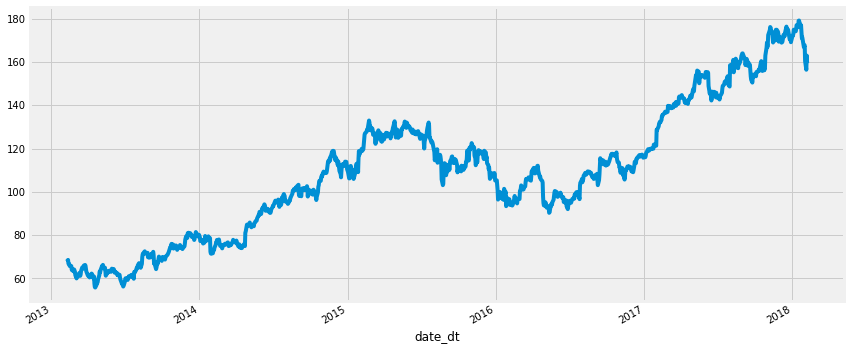

In [33]:
# The original non-stationary plot
df.close.plot(figsize=(13,6))

Dickey-Fuller criterion: p=0.855586


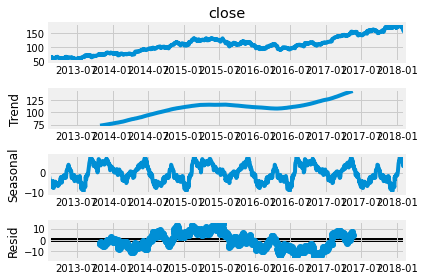

In [34]:
sm.tsa.seasonal_decompose(df.close, period=365).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(df.close)[1])

In [35]:
sm.tsa.seasonal_decompose(df['diff1'].dropna(), period=365).plot()

print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(df['diff1'].dropna())[1])

KeyError: 'diff1'

Null hypothesis for dickey-fuller test has been rejected (p value smaller than typical threshold of 0.05) anddf[diff1] is stationary (which makes it appropriate for models like ARIMA and SARIMA)

## More to come!! (Classic Time Series Models like ARIMA, SARIMA, VAG...) Feedback and comments are welcome!

## If this post was helpful, please upvote!